In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, forecast_by_week, train_test_split, evaluate_R_forecasts, process_R_results
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp,\
hp_color_plot, plot_forecast_entry
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import get_data, objectiveFNN
from datetime import datetime
import mxnet as mx
import gluonts
from PythonFiles.OverwrittenEvaluator import Evaluator, strict_coverage
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions#, Evaluator
from gluonts.mx.model.simple_feedforward import SimpleFeedForwardEstimator
mx.random.seed(0)
np.random.seed(0)
selected_regions = ['SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg', 'SK München']
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')

data_splits_dict, base_df = get_data(truncate=False, with_features=True)
locations = list(influenza_df.location.unique())
train = data_splits_dict["with_features_2001"][0]
test = data_splits_dict["with_features_2001"][1]
config = Configuration()

# Additions to existing functions to determine the Coverage only on defined seasons

In [28]:
def forecast_by_week1(config, train_set, test_set, locations, models_dict, seed=None, results_dict=None, restrict_to_season=None):
    if seed !=None:
        mx.random.seed(seed)
        np.random.seed(seed)
    #define the dicts that are going to be output later on
    evaluator_df_dict = {}
    forecasts_dict = {}
    #iterate through the given models and fit them
    for key in models_dict.keys():
        if results_dict == None:
            forecasts, tss = model(train_set, test_set, models_dict[key])
        else:
            forecasts = results_dict[f"{key}_forecasts"]
            tss = results_dict[f"{key}_tss"]
        # Splitting the forecasts into their weekly contribution
        split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[1]
        forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                        2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                        3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                        4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
        if restrict_to_season != None:
            forecasting_dict = {}
            start_date = forecast_dict[1][0].start_date.to_timestamp()
            daterange = pd.date_range(start=start_date, periods=len(forecast_dict[1][0].samples[0]),freq=config.parameters["freq"])
            #print(daterange)
            weeks = pd.Index(daterange.isocalendar().week)
            season_start_week = restrict_to_season[0]
            season_end_week = restrict_to_season[1]
            if season_start_week > season_end_week:
                season_slice = np.unique(weeks.get_indexer_for((weeks[(weeks<=season_end_week) | (weeks>=season_start_week)]))).tolist()
            else:
                season_slice = np.unique(weeks.get_indexer_for((weeks[(weeks<=season_end_week) & (weeks>=season_start_week)]))).tolist()
            splitting_tss = []
            for i in range(len(split_tss)):
                split_tss_index = split_tss[i].index
                tss = split_tss[i].copy()
                tss.index = tss.index.to_timestamp()
                #tss = tss[tss.index >= start_date]
                tss["weeks"] = tss.index.isocalendar().week
                if season_start_week > season_end_week:
                    tss = tss[(tss.index < start_date)|((tss["weeks"]<=season_end_week)|(tss["weeks"]>=season_start_week))]
                else:
                    tss = tss[(tss.index < start_date)|((tss["weeks"]<=season_end_week)&(tss["weeks"]>=season_start_week))]
                tss = tss[0]
                #print(tss[tss.index >= start_date])
                new_index = pd.date_range(start=tss.index[0], periods=len(tss),freq=config.parameters["freq"])
                tss.index = split_tss_index[:len(tss)]
                #print(tss[tss.index >= start_date])
                splitting_tss.append(tss)
            
            for week_ahead in [1, 2, 3, 4]:
                filtered_forecasts = []
                for location in range(len(forecast_dict[week_ahead])):
                    forecasts = forecast_dict[week_ahead][location]
                    filtered_forecasts.append(gluonts.model.forecast.SampleForecast(info=forecasts.info,
                                                                          item_id=forecasts.item_id,
                                                                          samples=forecasts.samples[:,season_slice],
                                                                          start_date=pd.Period(start_date,freq=config.parameters["freq"]),
                                                                         ))
                forecasting_dict[week_ahead] = filtered_forecasts
        # Evaluation with the quantiles of the configuration
        evaluator = Evaluator(quantiles=config.quantiles)
        evaluator_df = pd.DataFrame()         
        # iterate over the 4 different week-aheads
        for forecast in forecasting_dict.values():
            agg_metrics, item_metrics = evaluator(splitting_tss, forecast)
            d = {key for key in forecasting_dict if forecasting_dict[key] == forecast}
            for location in locations[:]:
                #rename location id to differentiate between the weekahead predictions and concat
                item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
                evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
            agg_metrics["item_id"] = f"aggregated {d}"
            evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics, index=[0])])
        # produce the average Quantile Loss metric by dividing the mean absolute QL through the number of involved locations per weekahead, which is usually 411 (each district)
        included_locations = [item_id for item_id in evaluator_df.item_id.unique() if "aggregated" not in item_id if "1" in item_id]
        evaluator_df.loc[evaluator_df.item_id.isin([item_id for item_id in evaluator_df.item_id if "aggregate" in item_id]), "mean_WIS"] = evaluator_df.loc[evaluator_df.item_id.isin([item_id for item_id in evaluator_df.item_id if "aggregate" in item_id]),"mean_absolute_QuantileLoss"]/len(included_locations)
        evaluator_df_dict[key] = evaluator_df
        forecasts_dict[key] = forecasting_dict
    return forecasts_dict, evaluator_df_dict

In [26]:
# hier verändern des processed_df
def process_R_results1(config, results_df, influenza_df, validation=False, restrict_to_season=None):
    '''
    Process the results_df by adding a date column and the corresponding true values.
    '''
    df = results_df.copy()
    # Split the values in the Time column saved as 822.1, 823.2,... as Time : 822, 823, ... and WeekAhead: 1, 2, ...
    df['Time'] = df['Time'].astype(str)
    df[['Time', 'WeekAhead']] = df['Time'].str.split('.', 1, expand=True)

    # Convert columns to appropriate types i.e., integer
    df['Time'] = df['Time'].astype(int)
    df['WeekAhead'] = df['WeekAhead'].astype(int)
    
    # The dates in the R representation of the influenza df are shifted by 1 position, example for SK München:
    # 821          0 2016-09-25
    # 822          0 2016-10-02
    # ...
    # 929          2 2018-10-21
    if validation:
        R_start = datetime(2018, 10, 7)
        window_length = 97
    else:
        R_start = datetime(2016, 10, 2) # first forecasted point
        window_length = 98
    R_end = datetime(2018, 10, 21)
    # determine the daterange of the forecast period
    daterange = pd.date_range(start=R_start, periods=len(results_df.Time.unique()),freq=config.parameters["freq"])
    influenza_df["date"] = pd.to_datetime(influenza_df["date"])
    # Iterate over the zipped pairs of time and date e.g., [(821,2016-09-25), ..., (929,2018-10-21)]  
    for i in zip(df.Time.unique(), daterange): 
        df.loc[df.Time == i[0], "date"] = i[1]
        
    df["date"] = pd.to_datetime(df["date"])
    
    # rename the location column so it matches with the influenza location columnname
    df.rename(columns = {'Location':'location'}, inplace = True)
    df = df.merge(influenza_df[["date", "value", "location"]], on = ["date", "location"]) 
    df.rename(columns = {'value':'true_value'}, inplace = True)
    
    # truncate the predictions to lie within the same date range
    start_date = df.loc[df["WeekAhead"]==4,"date"].min()
    end_date = df.loc[df["WeekAhead"]==1,"date"].max()
    # the gluonts models only have a one week ahead forecast up to 98 data points
    # therefore set the start and the length to equal the gluonts model period
    end_date = pd.date_range(start=start_date, freq=config.parameters["freq"], periods=window_length)[-1:][0]
    df = df.loc[(df["date"]>=start_date) & (df["date"]<=end_date)]
    if restrict_to_season != None:
        df["week"] = df["date"].dt.isocalendar().week
        season_start_week = restrict_to_season[0]
        season_end_week = restrict_to_season[1]
        if season_start_week > season_end_week:
            df = df.loc[(df["week"]<=season_end_week) | (df["week"]>=season_start_week),:]
        else:
            df = df.loc[(df["week"]<=season_end_week) & (df["week"]>=season_start_week),:]
    return df

# Plots

In [4]:
# Load in the models
# gluonts models foreccasts
results_dict = np.load('/home/reffert/DeepAR_InfluenzaForecast/ignore_this_directory/default_models.npy',allow_pickle='TRUE').item()
# R forecasts
results_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/results.csv", sep=',')

Running evaluation: 411it [00:02, 182.26it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 181.50it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 178.98it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 180.76it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 173.87it/s

Running evaluation: 411it [00:03, 136.37it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 134.98it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 133.63it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 122.16it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 136.19it/s

Evaluating 1/4 -- 2023-07-17 09:13:17.854131
Evaluating 2/4 -- 2023-07-17 09:13:53.827183
Evaluating 3/4 -- 2023-07-17 09:14:30.169217
Evaluating 4/4 -- 2023-07-17 09:15:06.386746


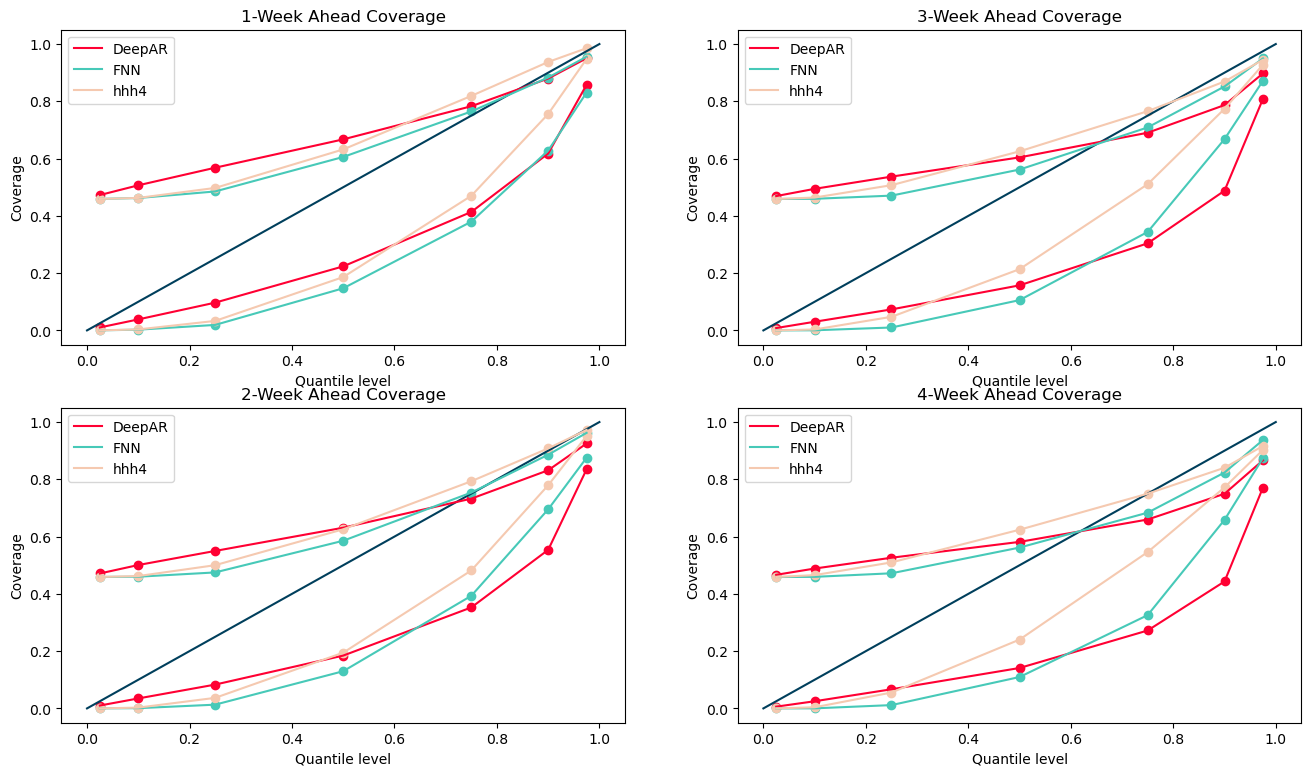

In [29]:
restrict_to_season = [40, 20]
f, e = forecast_by_week1(config, None, None, locations, models_dict = {"DeepAR":None, "FNN":None}, seed=0, results_dict=results_dict, restrict_to_season=restrict_to_season)
processed_df = process_R_results1(config, results_df, influenza_df, restrict_to_season=restrict_to_season)
df_dict = {"hhh4":{1:processed_df[processed_df.WeekAhead == 1].copy(),
           2:processed_df[processed_df.WeekAhead == 2].copy(),
           3:processed_df[processed_df.WeekAhead == 3].copy(),
           4:processed_df[processed_df.WeekAhead == 4].copy()}}
evaluator_df = evaluate_R_forecasts(config, df_dict["hhh4"], locations, processed_df)
e["hhh4"] = evaluator_df

colors = config.colors[:3]+config.colors[12:]
plot_coverage(config, e, colors=colors, strict=True)
os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation/png_files')
#plt.savefig(f"CoveragePlot.png")
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')

In [6]:
coverage_cols = [col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "Coverage" in col]
#quantile_cols = [col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "QuantileLoss" in col]
quantile_cols = [f"QuantileLoss[{quantile}]" for quantile in config.quantiles]
selected_regions = [f"{location} "+"{"+ f"{week_ahead}"+"}" for location in locations for week_ahead in [1]]#, 2, 3, 4]]
#np.array([df[f"QuantileLoss[{quantile}]"] for quantile in config.quantiles]).mean()
for key in evaluator_df_dict.keys():
    print(key)
    selected_df = evaluator_df_dict[key].loc[evaluator_df_dict[key]["item_id"].isin(selected_regions),:]
    aggregated_df = evaluator_df_dict[key].loc[evaluator_df_dict[key]["item_id"].isin([i for i in evaluator_df_dict[key]["item_id"] if "aggregated" in i]),:]
    print(aggregated_df[["item_id"] + coverage_cols])
    selected_df["individual_WIS"] = selected_df[quantile_cols].mean(axis=1)
    #print(selected_df[["item_id", "individual_WIS"]])
    #print(selected_df[["item_id"]+[col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "QuantileLoss" in col]])
    #print(selected_df["individual_WIS"].mean()) # is equal to the WIS score of aggregated {1}


DeepAR
          item_id  Coverage[0.025]  StrictCoverage[0.025]  Coverage[0.1]  \
0  aggregated {1}         0.644893               0.006753       0.667114   
0  aggregated {2}         0.643950               0.006554       0.663191   
0  aggregated {3}         0.642534               0.005363       0.659069   
0  aggregated {4}         0.640871               0.003972       0.655172   

   StrictCoverage[0.1]  Coverage[0.25]  StrictCoverage[0.25]  Coverage[0.5]  \
0             0.025150        0.707235              0.063608       0.772283   
0             0.022742        0.695318              0.054471       0.748523   
0             0.019713        0.686901              0.048066       0.730970   
0             0.016361        0.679850              0.043771       0.716048   

   StrictCoverage[0.5]  Coverage[0.75]  StrictCoverage[0.75]  Coverage[0.9]  \
0             0.148965        0.849124              0.289488       0.915487   
0             0.122474        0.816004              0.2434

/tmp/ipykernel_3780620/3689273673.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["individual_WIS"] = selected_df[quantile_cols].mean(axis=1)
/tmp/ipykernel_3780620/3689273673.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["individual_WIS"] = selected_df[quantile_cols].mean(axis=1)
/tmp/ipykernel_3780620/3689273673.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

# Plots for validation

In [30]:
validation_config = Configuration()
validation_config.train_start_time = datetime(1999,1,1,0,0,0)
validation_config.train_end_time = datetime(2018,9,30,23,0,0)
validation_config.test_end_time = datetime(2020,9,30,23,0,0)

In [31]:
# Load in the models
# gluonts models foreccasts
default_results_dict = np.load('/home/reffert/DeepAR_InfluenzaForecast/ignore_this_directory/default_models_validation.npy',allow_pickle='TRUE').item()
tuned_results_dict = np.load('/home/reffert/DeepAR_InfluenzaForecast/ignore_this_directory/tuned_models_validation.npy',allow_pickle='TRUE').item()
# R forecasts
validation_results_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/validation_results.csv", sep=',')

Running evaluation: 411it [00:04, 89.85it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:04, 89.28it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:04, 89.77it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:04, 89.94it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:04, 90.54it/s]
/ho

Evaluating 1/4 -- 2023-07-17 09:54:31.646348
Evaluating 2/4 -- 2023-07-17 09:54:55.036640
Evaluating 3/4 -- 2023-07-17 09:55:18.160888
Evaluating 4/4 -- 2023-07-17 09:55:41.490818


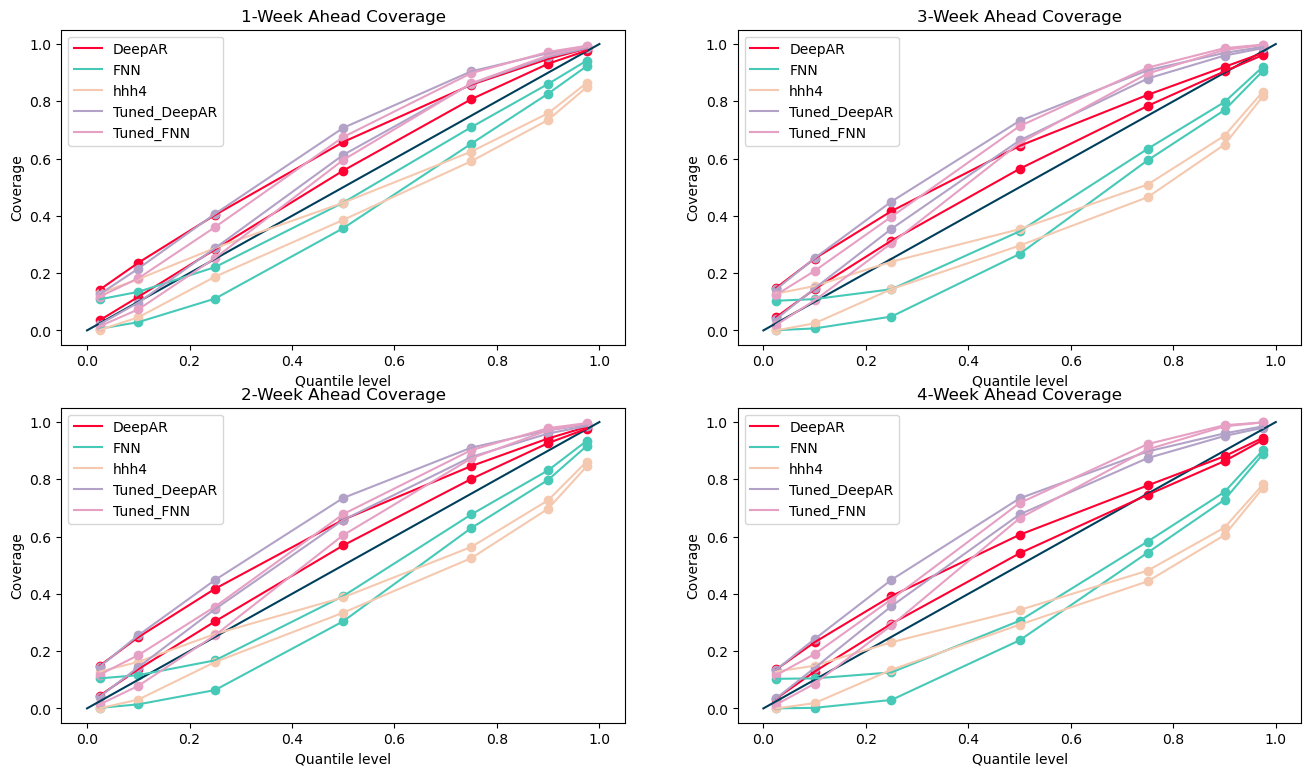

In [35]:
restrict_to_season = [2, 16]
f, evaluator_df_dict = forecast_by_week1(validation_config, None, None, locations, models_dict = {"DeepAR":None, "FNN":None}, seed=0, results_dict=default_results_dict, restrict_to_season=restrict_to_season)
tuned_forecasts_dict, tuned_evaluator_df_dict = forecast_by_week1(validation_config, None, None, locations, models_dict = {"Tuned_DeepAR":None, "Tuned_FNN":None}, seed=0, results_dict=tuned_results_dict, restrict_to_season=restrict_to_season)
processed_df = process_R_results1(validation_config, validation_results_df, influenza_df, restrict_to_season=restrict_to_season)
df_dict = {"hhh4":{1:processed_df[processed_df.WeekAhead == 1].copy(),
           2:processed_df[processed_df.WeekAhead == 2].copy(),
           3:processed_df[processed_df.WeekAhead == 3].copy(),
           4:processed_df[processed_df.WeekAhead == 4].copy()}}
evaluator_df = evaluate_R_forecasts(validation_config, df_dict["hhh4"], locations, processed_df)
e["hhh4"] = evaluator_df

evaluator_df_dict["hhh4"] = evaluator_df
for key in list(tuned_evaluator_df_dict.keys()):
    evaluator_df_dict[key] = tuned_evaluator_df_dict[key]
    
colors = config.colors[:3]+config.colors[12:]
plot_coverage(validation_config, evaluator_df_dict, colors=colors, strict=True)
os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation/png_files')
#plt.savefig(f"CoveragePlot.png")
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')